In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

TensorFlow version: 2.13.0


## Data/Code Prep
Prepare the data and some code utils

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [3]:
## split training and test sets into two separate sets
# train one on 0..4, another on 5..9
x_train1 = x_train[y_train < 5]
y_train1 = y_train[y_train < 5]

x_train2 = x_train[y_train >= 5]
y_train2 = y_train[y_train >= 5]

x_test1 = x_test[y_test < 5]
y_test1 = y_test[y_test < 5]

x_test2 = x_test[y_test >= 5]
y_test2 = y_test[y_test >= 5]

In [4]:
### full dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(10000).batch(32)


test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### dataset with labels 0..4
train_ds1 = tf.data.Dataset.from_tensor_slices(
    (x_train1, y_train1)
).shuffle(10000).batch(32)


test_ds1 = tf.data.Dataset.from_tensor_slices((x_test1, y_test1)).batch(32)

### dataset with labels 5..9
train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train2, y_train2)
).shuffle(10000).batch(32)


test_ds2 = tf.data.Dataset.from_tensor_slices((x_test2, y_test2)).batch(32)

#### Training utilities
train steps, loops and some special loss classes for the Mixture of Expert (MoE) Models.

In [334]:
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:

        # training = True only needed if some layers behave differently during training than inference
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

def train_loop(model, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 5):
    train_step_tf = tf.function(train_step)
    test_step_tf = tf.function(test_step)
    for epoch in range(epochs):

        # reset metrics at the start of the next epoch
        # like opimizer.zero_grad?
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for images, labels in train_ds:
            train_step_tf(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

        for test_images, test_labels in test_ds:
            test_step_tf(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

        print(
            f'Epoch {epoch + 1}',
            f'Loss: {train_loss.result()}',
            f'Accuracy: {train_accuracy.result()*100}',
            f'Test Loss: {test_loss.result()}',
            f'Test Accuracy: {test_accuracy.result() * 100}'
        )


class MoE_loss(tf.keras.losses.Loss):

    def __init__(self, name, loss_fn, shift = False, alpha = 1, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.shift = shift
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y_true, y_pred):
        # outputted predictions as a tuple
        y_pred_m1 = y_pred[0]
        y_pred_m2 = y_pred[1]
        gv_m1 = y_pred[2]
        gv_m2 = y_pred[3]

        m1_loss = self.loss_fn(y_true, y_pred_m1, sample_weight=gv_m1)
        m2_loss = self.loss_fn(y_true, y_pred_m2, sample_weight=gv_m2)
        loss = m1_loss + m2_loss
    
        if self.shift:
            loss += self.alpha * (gv_m1 / (gv_m2 + 1.0e-8))**self.beta

        return tf.reduce_mean(loss)

class MoE_accuracy(tf.keras.metrics.Metric):
    def __init__(self, name, base_metric, **kwargs):
        super().__init__(**kwargs)
        self.base_metric = base_metric
        self.moe_acc = self.add_weight('moe_acc', initializer='zeros')
        # self.base_metric_val = -1
        
    def update_state(self, y_true, y_pred):
        """
        y_true are actual predictions
        y_pred is a tuple containing two separate model predictions and gating values
        """
        
        y_pred_m1 = y_pred[0]
        y_pred_m2 = y_pred[1]
        gv_m1 = y_pred[2]
        gv_m2 = y_pred[3]

        combined_predictions = tf.expand_dims(gv_m1, axis=-1) * y_pred_m1 +\
            tf.expand_dims(gv_m2, axis=-1)* y_pred_m2

        self.moe_acc.assign(self.base_metric(y_true, combined_predictions))

    def reset_states(self):
        self.base_metric.reset_states()
        self.moe_acc.assign(0)

    def result(self):
        return self.moe_acc



## Base models
Train three base models using labels 0..4, 5..9 and all labels.
We can combine these in later models and use as baseline of performance.

In [ ]:
# build a tf.keras model
class TfModel(Model):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        # dense seems to be feed forward (makes sense)
        # also only output dimensions seem to be specified?
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):

        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)



In [7]:
# specify loss metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
# trained on labels 0..4
model1 = TfModel()
optimizer1 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model1, train_ds1, test_ds1, optimizer1, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)
model1.save_weights('./model1/model1.keras')

# trained on labels 5..9
model2 = TfModel()
optimizer2 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model2, train_ds2, test_ds2, optimizer2, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)
model2.save_weights('./model2/model2.keras')



Epoch 1 Loss: 0.07443707436323166 Accuracy: 97.7251968383789 Test Loss: 0.0236126147210598 Test Accuracy: 99.28001403808594
Epoch 2 Loss: 0.020631739869713783 Accuracy: 99.39534759521484 Test Loss: 0.020950336009263992 Test Accuracy: 99.29946899414062
Epoch 3 Loss: 0.011508244089782238 Accuracy: 99.63720703125 Test Loss: 0.023149780929088593 Test Accuracy: 99.24109649658203
Epoch 1 Loss: 0.11260265856981277 Accuracy: 96.37804412841797 Test Loss: 0.05961921438574791 Test Accuracy: 97.7988052368164
Epoch 2 Loss: 0.035338643938302994 Accuracy: 98.92191314697266 Test Loss: 0.03960174694657326 Test Accuracy: 98.76568603515625
Epoch 3 Loss: 0.02082570642232895 Accuracy: 99.34022521972656 Test Loss: 0.03351496532559395 Test Accuracy: 98.70397186279297


NameError: name 'test_ds3' is not defined

In [9]:
# trained on all labels
model3 = TfModel()
optimizer3 = tf.keras.optimizers.Adam(weight_decay=0.1)
train_loop(model3, train_ds, test_ds, optimizer3, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)
model3.save_weights('./model3/model3.keras')

Epoch 1 Loss: 0.13503390550613403 Accuracy: 95.9800033569336 Test Loss: 0.07552213966846466 Test Accuracy: 97.6199951171875
Epoch 2 Loss: 0.04979102686047554 Accuracy: 98.4366683959961 Test Loss: 0.051277611404657364 Test Accuracy: 98.1500015258789
Epoch 3 Loss: 0.03227425366640091 Accuracy: 99.01166534423828 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './model3/model3.keras', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

## Combined Models
Here we have a model with a gating function that chooses the best network. Its not quite a true MoE as we combine the outputs before calculating the loss. My understanding is that this will result in the learnt gating assignment being a linear combination of each of the experts, rather than assigning an observation to a single expert.

In [344]:
class CombinedModel(Model):
    def __init__(self, model1, model2, model1_trainable = False, model2_trainable = False, input_shape = (1,28,28,1)):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dc1 = Dense(2, activation='softmax')

        # clone the models
        self.model1 = tf.keras.models.clone_model(model1)
        self.model1.build(input_shape)
        self.model1.set_weights(model1.get_weights())
        self.model1.trainable = model1_trainable

        self.model2 = tf.keras.models.clone_model(model2)
        self.model2.build(input_shape)
        self.model2.set_weights(model2.get_weights())
        self.model2.trainable = model2_trainable

    
    def _get_gating_values(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.dc1(x)


    def call(self, x):
        # get frozen model outputs
        m1 = self.model1(x)
        m2 = self.model2(x)
        stacked_models = tf.stack([m1, m2], axis=1)

        # calculate gating values
        gating_values = self._get_gating_values(x)
        
        # combine models with gating values
        gating_values = tf.expand_dims(gating_values, axis = -1)
        x = tf.matmul(gating_values, stacked_models, transpose_a=True)
        return tf.squeeze(x, axis = 1)


In [13]:
# train with both model1, model2 frozen - should see performance that averages model1/model2
optimizer = tf.keras.optimizers.Adam()
combined_model1 = CombinedModel(model1, model2)
train_loop(combined_model1, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.10440971702337265 Accuracy: 97.45333099365234 Test Loss: 0.10078127682209015 Test Accuracy: 97.25999450683594
Epoch 2 Loss: 0.07815110683441162 Accuracy: 98.16500091552734 Test Loss: 0.09391076117753983 Test Accuracy: 97.43999481201172
Epoch 3 Loss: 0.06756610423326492 Accuracy: 98.44166564941406 Test Loss: 0.09996861964464188 Test Accuracy: 97.1199951171875


In [14]:
# train with model2 unfrozen - enables it to fit to unseen labels - hypothesise that eventually the model will favor model2 for everything
optimizer = tf.keras.optimizers.Adam()
combined_model2 = CombinedModel(model1, model2, model2_trainable=True)
train_loop(combined_model2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.06877808272838593 Accuracy: 98.01667022705078 Test Loss: 0.05309878662228584 Test Accuracy: 98.25
Epoch 2 Loss: 0.030689261853694916 Accuracy: 99.07833099365234 Test Loss: 0.056898508220911026 Test Accuracy: 98.16999816894531
Epoch 3 Loss: 0.016965648159384727 Accuracy: 99.50333404541016 Test Loss: 0.050012245774269104 Test Accuracy: 98.43999481201172


In [ ]:
# train with model2 unfrozen - enables it to fit to unseen labels - hypothesise that eventually the model will favor model2 for everything
### TRY THIS ONE WITH 15 ITERS - what happens to the gating values? shift completely to model2? 3 epochs doesn't seem enough
# also - have you  actually implemented an MoE correctly - both networks should output their values, then their errors should be proportionally combined
optimizer = tf.keras.optimizers.Adam()
combined_model2 = CombinedModel(model1, model2, model2_trainable=True)
train_loop(combined_model2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 15)

In [15]:
random_init_model = TfModel()
random_init_model.build(x_train.shape)

# train with model3 - trained on all labels, but frozen, and a randomly initialised model - hypothesise that randomly initialised model may not learn due to good performance from model3
optimizer = tf.keras.optimizers.Adam()
combined_model3 = CombinedModel(model3, random_init_model, model2_trainable=True)
train_loop(combined_model3, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.023606635630130768 Accuracy: 99.26000213623047 Test Loss: 0.0540674589574337 Test Accuracy: 98.20999908447266
Epoch 2 Loss: 0.023873724043369293 Accuracy: 99.23999786376953 Test Loss: 0.05406544357538223 Test Accuracy: 98.20999908447266
Epoch 3 Loss: 0.023881398141384125 Accuracy: 99.23833465576172 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266


In [21]:
random_init_model = TfModel()
random_init_model.build(x_train.shape)

# train with model3 - trained on all labels, but frozen, and a randomly initialised model - hypothesise that randomly initialised model may not learn due to good performance from model3
## run for more iters - see if it does result in a shift?
optimizer = tf.keras.optimizers.Adam()
combined_model4 = CombinedModel(model3, random_init_model, model2_trainable=True)
train_loop(combined_model4, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 15)

Epoch 1 Loss: 0.023521795868873596 Accuracy: 99.26166534423828 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 2 Loss: 0.023874491453170776 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 3 Loss: 0.023874463513493538 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 4 Loss: 0.02387445606291294 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 5 Loss: 0.02387448586523533 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 6 Loss: 0.02387448400259018 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 7 Loss: 0.023874465376138687 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accuracy: 98.20999908447266
Epoch 8 Loss: 0.023874474689364433 Accuracy: 99.23999786376953 Test Loss: 0.054067570716142654 Test Accurac

## MoE models
Here we use genuine MoE where the loss is calculated for each expert and then weighted proportionally. We add a shift penalty term as well which encourages the gating values to shift towards the unfrozen model - model 2. 

In [ ]:
class MoE(Model):
    def __init__(self, model1, model2, model1_trainable = False, model2_trainable = False, input_shape = (1,28,28,1)):
        super().__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dc1 = Dense(2, activation='softmax')

        # clone the models
        self.model1 = tf.keras.models.clone_model(model1)
        self.model1.build(input_shape)
        self.model1.set_weights(model1.get_weights())
        self.model1.trainable = model1_trainable

        self.model2 = tf.keras.models.clone_model(model2)
        self.model2.build(input_shape)
        self.model2.set_weights(model2.get_weights())
        self.model2.trainable = model2_trainable

    def _get_gating_values(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.dc1(x)

    def call(self, x):
        # get frozen model outputs
        m1 = self.model1(x)
        m2 = self.model2(x)

        # calculate gating values
        gating_values = self._get_gating_values(x)
        return m1, m2, gating_values[:,0], gating_values[:,1]

    def predict(self, x):
        return self.combine_predictions(x)

    def combine_predictions(self, x):
        preds = self.call(x)
        y_pred_m1 = preds[0]
        y_pred_m2 = preds[1]
        gv_m1 = preds[2]
        gv_m2 = preds[3]

        combined_predictions = tf.expand_dims(gv_m1, axis=-1) * y_pred_m1 +\
            tf.expand_dims(gv_m2, axis=-1)* y_pred_m2

        return combined_predictions

In [349]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = MoE_accuracy(name='train_accuracy', base_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='base_train_acc'))#tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = MoE_accuracy(name='test_accuracy', base_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='base_test_acc'))

In [350]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn)


optimizer = tf.keras.optimizers.Adam()
MOE1 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE1, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.11969370394945145 Accuracy: 97.07333374023438 Test Loss: 0.06023307517170906 Test Accuracy: 98.06999969482422
Epoch 2 Loss: 0.030337385833263397 Accuracy: 99.0199966430664 Test Loss: 0.04803996905684471 Test Accuracy: 98.41999816894531
Epoch 3 Loss: 0.01736910454928875 Accuracy: 99.4316635131836 Test Loss: 0.06699944287538528 Test Accuracy: 98.16999816894531


In [351]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True)


optimizer = tf.keras.optimizers.Adam()
MOE2 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE2, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.11964865028858185 Accuracy: 96.77999877929688 Test Loss: 0.059774283319711685 Test Accuracy: 98.05999755859375
Epoch 2 Loss: 0.031724121421575546 Accuracy: 98.99666595458984 Test Loss: 0.05979447811841965 Test Accuracy: 97.95999908447266
Epoch 3 Loss: 0.01711590401828289 Accuracy: 99.47999572753906 Test Loss: 0.04897588491439819 Test Accuracy: 98.54000091552734


In [352]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True, beta =.05)


optimizer = tf.keras.optimizers.Adam()
MOE3 = MoE(model1, model2, model2_trainable=True)
train_loop(MOE3, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.12028342485427856 Accuracy: 96.70999908447266 Test Loss: 0.05973048880696297 Test Accuracy: 97.95999908447266
Epoch 2 Loss: 0.03167799115180969 Accuracy: 99.02999877929688 Test Loss: 0.04479728639125824 Test Accuracy: 98.52999877929688
Epoch 3 Loss: 0.01722921058535576 Accuracy: 99.47833251953125 Test Loss: 0.05456838384270668 Test Accuracy: 98.4000015258789


In [362]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn)

# randomly initialise
random_init_model = TfModel()
random_init_model.build(x_train.shape)

optimizer = tf.keras.optimizers.Adam()
MOE4 = MoE(model1, random_init_model, model2_trainable=True)
train_loop(MOE4, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.13562898337841034 Accuracy: 96.07333374023438 Test Loss: 0.060285866260528564 Test Accuracy: 98.1199951171875
Epoch 2 Loss: 0.039100561290979385 Accuracy: 98.7683334350586 Test Loss: 0.05959385260939598 Test Accuracy: 98.0
Epoch 3 Loss: 0.021723438054323196 Accuracy: 99.25 Test Loss: 0.06047194451093674 Test Accuracy: 98.13999938964844


In [363]:
# specify loss metrics
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
loss_object = MoE_loss(name = 'moe_loss', loss_fn=loss_fn, shift=True)

# randomly initialise
random_init_model = TfModel()
random_init_model.build(x_train.shape)

optimizer = tf.keras.optimizers.Adam()
MOE5 = MoE(model1, random_init_model, model2_trainable=True)
train_loop(MOE5, train_ds, test_ds, optimizer, loss_object, train_loss, train_accuracy, test_loss, test_accuracy, train_step, test_step, epochs = 3)

Epoch 1 Loss: 0.13887068629264832 Accuracy: 95.98500061035156 Test Loss: 0.06161321699619293 Test Accuracy: 97.93000030517578
Epoch 2 Loss: 0.04486340284347534 Accuracy: 98.62999725341797 Test Loss: 0.049634359776973724 Test Accuracy: 98.38999938964844
Epoch 3 Loss: 0.025160547345876694 Accuracy: 99.19499969482422 Test Loss: 0.060589537024497986 Test Accuracy: 98.15999603271484


## Results
We can see below - when model 2 (model trained on 5..9) is fitted alongside a frozen model 1 (combined model 2) performance is best and model 2 improves its performance on the whole dataset significantly (increases from 48% acc to 82% acc)

Combined models 3 and 4 which have a frozen network trained on the whole dataset, don't seem to update the randomly initialised model and gating values seem to exclusively focus on the 'right' network (i.e. the frozen one).

In [364]:
def print_acc(model, model_name):
    acc = lambda y_pred, y_true: 100 *  float(tf.reduce_sum(tf.cast(tf.argmax(y_pred, axis=-1)==y_true, tf.int64)) / y_true.shape)
    preds = model.predict(x_test)
    print(
        f"{model_name}: {acc(preds, y_test):.3f}%"
    )

print_acc(model1, 'Model 1')
print_acc(model2, 'Model 2')
print_acc(model3, 'Model 3')
print_acc(combined_model1, 'Combined Model 1')
print_acc(combined_model2, 'Combined Model 2')
print_acc(combined_model2.model2, 'Combined Model 2 (Trained Model 2)')
print_acc(combined_model3, 'Combined Model 3')
print_acc(combined_model3.model2, 'Combined Model 3 (Trained random init model)')
print_acc(combined_model4, 'Combined Model 4 (15 EPOCHS)')
print_acc(combined_model4.model2, 'Combined Model 4 (Trained random init model) (15 EPOCHS)')
print_acc(MOE1, 'MoE 1')
print_acc(MOE1.model2, 'MoE 1 (trained model 2)')
print_acc(MOE2, 'MoE 2 - with shift')
print_acc(MOE2.model2, 'MoE 2 - with shift (trained model 2)')
# print_acc(MOE3, 'MoE 3 - with shift and large beta')
# print_acc(MOE3.model2, 'MoE 3 - with shift and large beta (trained model 2)')
print_acc(MOE4, 'MoE 4')
print_acc(MOE4.model2, 'MoE 4 (Trained random init model)')
print_acc(MOE5, 'MoE 5 - with shift')
print_acc(MOE5.model2, 'MoE 5 - with shift (Trained random init model)')

313/313 [==============================] - 1s 4ms/step
Model 1: 51.000%
313/313 [==============================] - 1s 4ms/step
Model 2: 47.980%
313/313 [==============================] - 1s 4ms/step
Model 3: 98.210%
313/313 [==============================] - 3s 8ms/step
Combined Model 1: 97.120%
313/313 [==============================] - 3s 9ms/step
Combined Model 2: 98.440%
313/313 [==============================] - 1s 4ms/step
Combined Model 2 (Trained Model 2): 81.710%
313/313 [==============================] - 3s 9ms/step
Combined Model 3: 98.210%
313/313 [==============================] - 1s 4ms/step
Combined Model 3 (Trained random init model): 8.920%
313/313 [==============================] - 3s 8ms/step
Combined Model 4 (15 EPOCHS): 98.210%
313/313 [==============================] - 1s 5ms/step
Combined Model 4 (Trained random init model) (15 EPOCHS): 9.820%
MoE 1: 98.170%
313/313 [==============================] - 2s 6ms/step
MoE 1 (trained model 2): 98.170%
MoE 2 - with shift

In [331]:
def get_gating_values_by_result(model, x_test, y_test):
    preds = model.predict(x_test)
    gating_values = model._get_gating_values(x_test)

    df = pd.DataFrame(
        {
            'model1_share': tf.get_static_value(gating_values[:,0]),
            'model2_share': tf.get_static_value(gating_values[:,1]),
            'predicted_labels': tf.get_static_value(tf.argmax(preds, axis=-1)),
            'true_labels':y_test
            }
        )

    df.loc[:,'true_labels'] = pd.Categorical(df.loc[:, 'true_labels'])
    df.loc[:,'predicted_labels'] = pd.Categorical(df.loc[:, 'predicted_labels'])

    return df.melt(
        id_vars = ('true_labels', 'predicted_labels'),
        value_vars = ('model1_share', 'model2_share')
        )

def plot_gating_values_by_result(result_df):

    fig, ax = plt.subplots(1,2,figsize = (15, 7))
    ax = ax.flatten()

    sns.boxplot(data = result_df, x ='true_labels', y = 'value', hue='variable', ax = ax[0], showfliers = False)
    sns.boxplot(data = result_df, x ='predicted_labels', y = 'value', hue='variable', ax = ax[1], showfliers = False)
    plt.show();


313/313 [==============================] - 2s 7ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

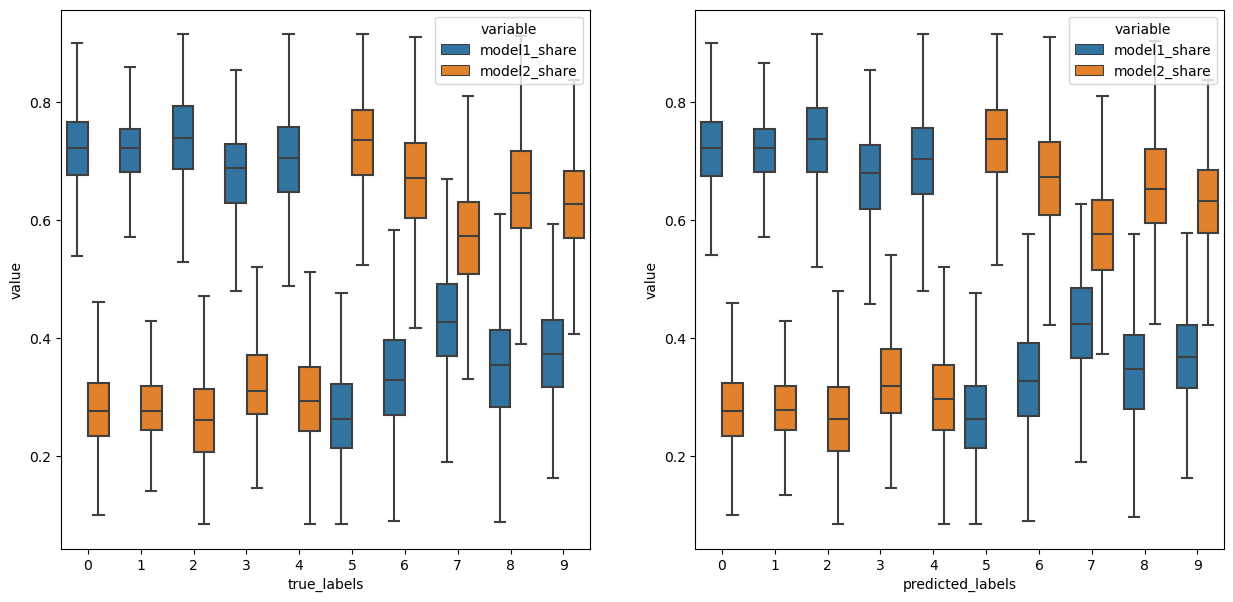

In [354]:
# combined model 1 - both experts frozen - can see that gating values assign to the appropriate expert
result_df = get_gating_values_by_result(combined_model1, x_test, y_test)
plot_gating_values_by_result(result_df)


313/313 [==============================] - 2s 7ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

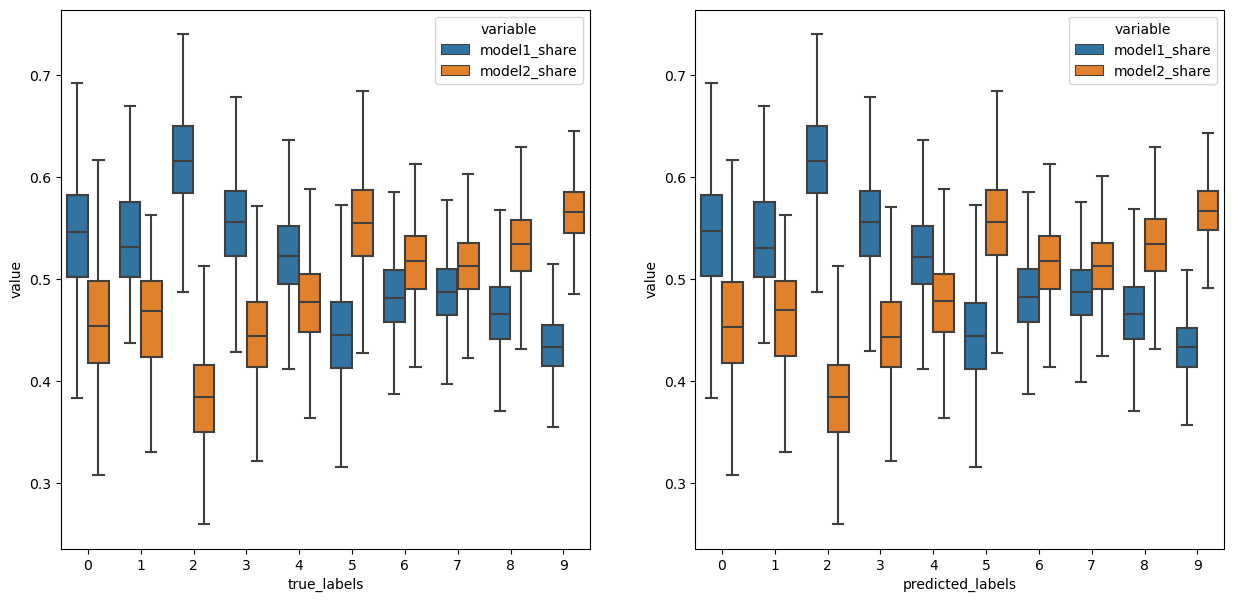

In [355]:
# model 2 (unfrozen) has gating values increase for labels 0..4 (compared to frozen version above) but gating values also decrease for model 2 for the labels it was originally trained on (5..9)
# perhaps due to the comparable performance of model 2 on 0..4 the gating network becomes less certain of proportional assignments?
result_df = get_gating_values_by_result(combined_model2, x_test, y_test)
plot_gating_values_by_result(result_df)

313/313 [==============================] - 3s 8ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

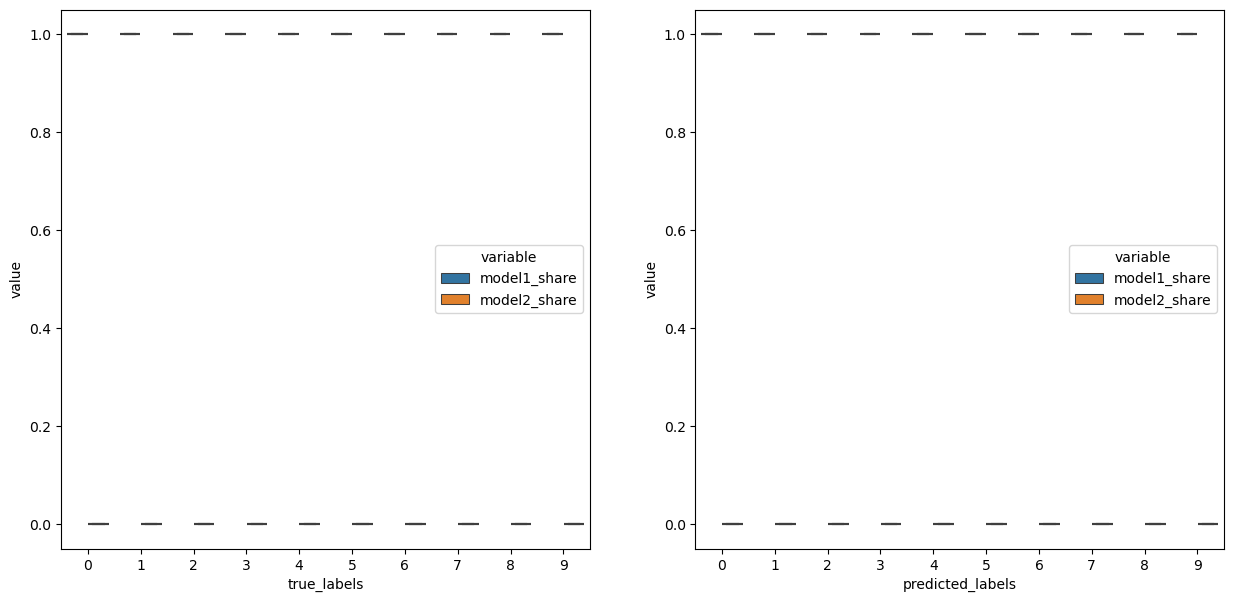

In [356]:
result_df = get_gating_values_by_result(combined_model3, x_test, y_test)
plot_gating_values_by_result(result_df)

313/313 [==============================] - 3s 8ms/step


c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

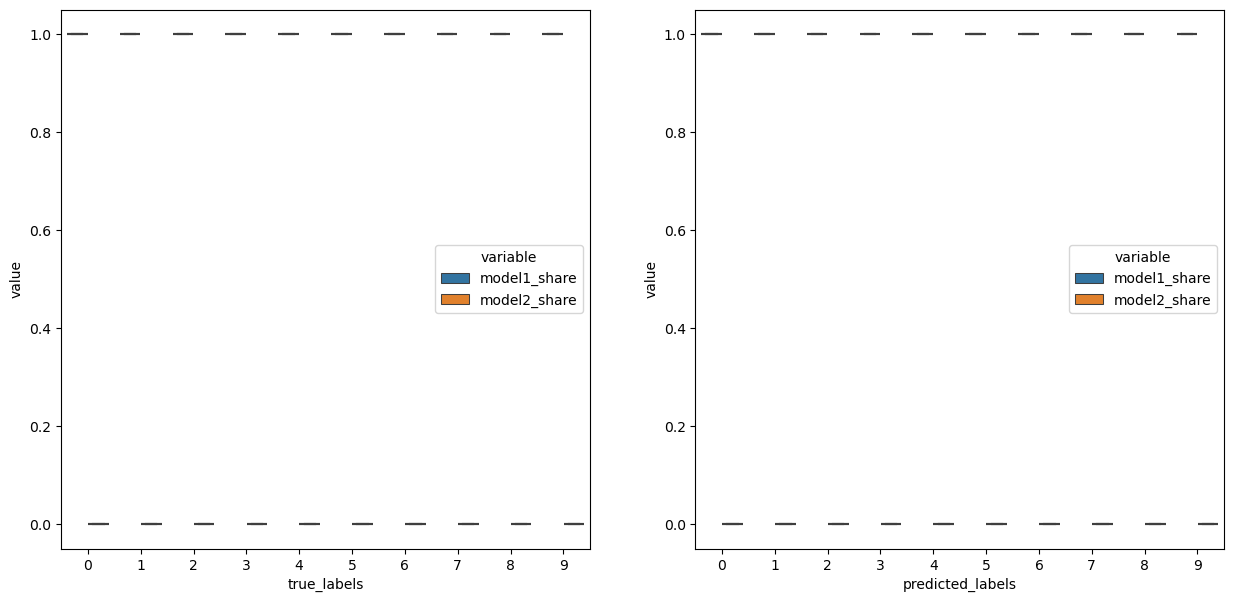

In [357]:
result_df = get_gating_values_by_result(combined_model4, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

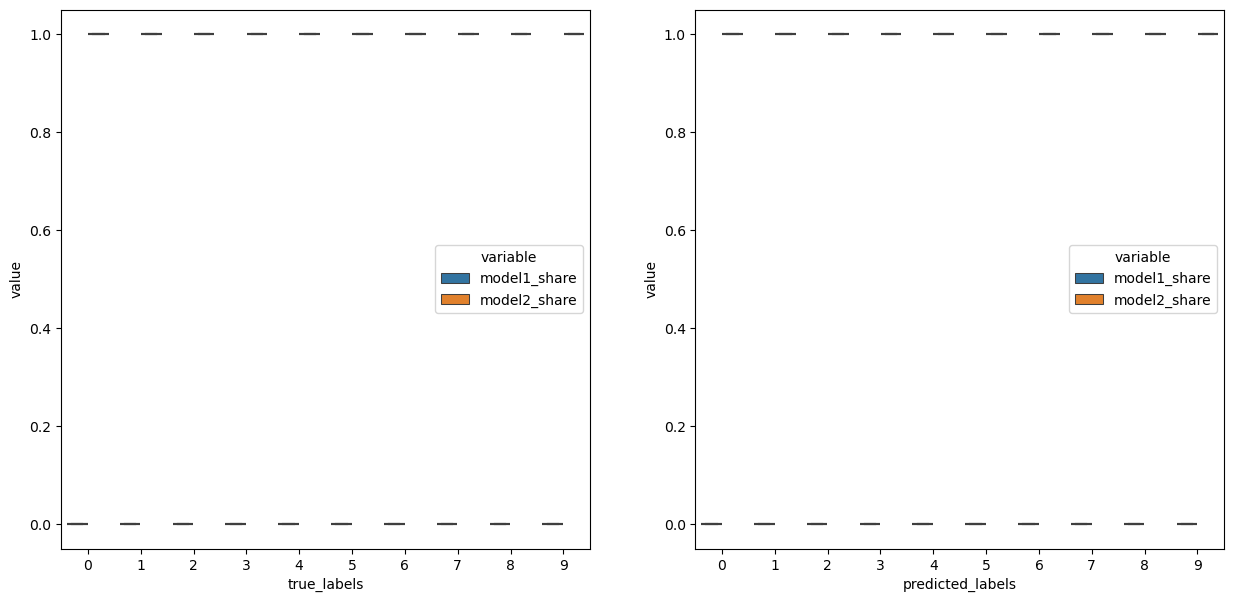

In [358]:
# MoE model - frozen weights - only predicts labels 0..4 ? 
result_df = get_gating_values_by_result(MOE1, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

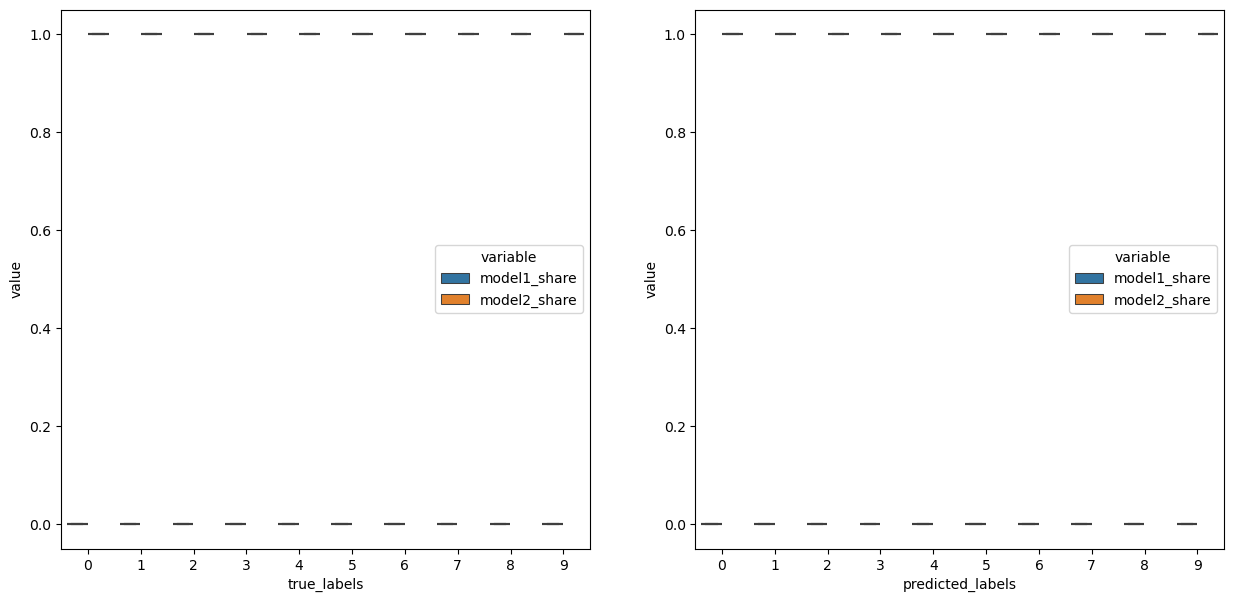

In [359]:
result_df = get_gating_values_by_result(MOE2, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

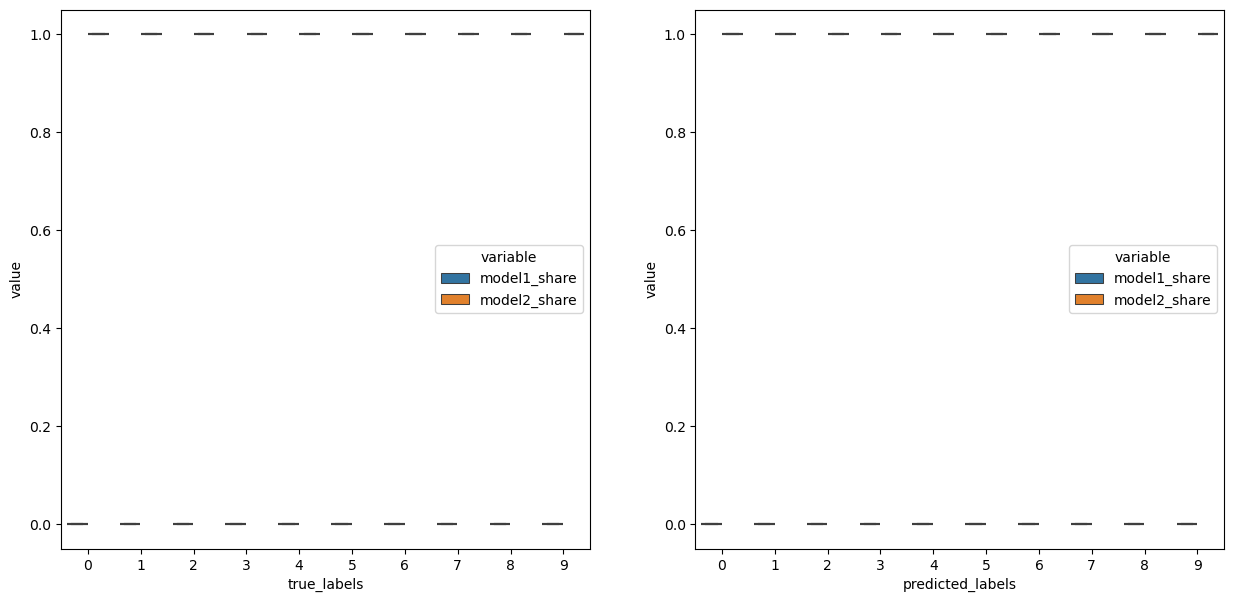

In [360]:
result_df = get_gating_values_by_result(MOE3, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

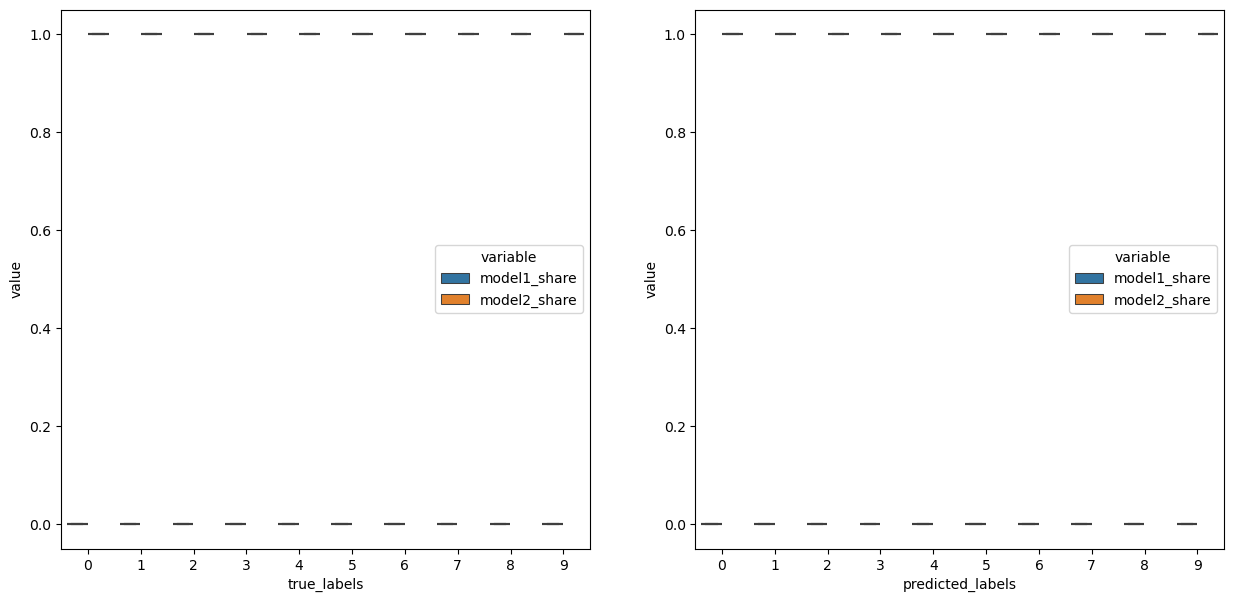

In [365]:
result_df = get_gating_values_by_result(MOE4, x_test, y_test)
plot_gating_values_by_result(result_df)

c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\61417\anaconda3\envs\tensorflow_intro\Lib\site-packages\seaborn\cat

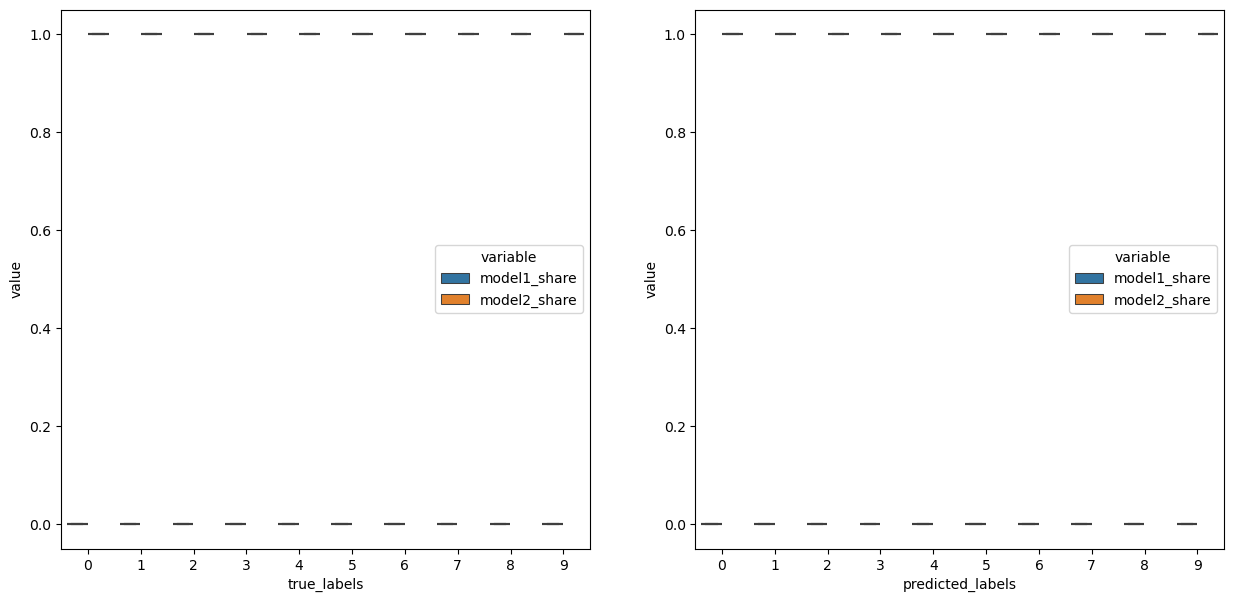

In [366]:
result_df = get_gating_values_by_result(MOE5, x_test, y_test)
plot_gating_values_by_result(result_df)

tf.Tensor([[2.7872276e-11 1.0000000e+00]], shape=(1, 2), dtype=float32)


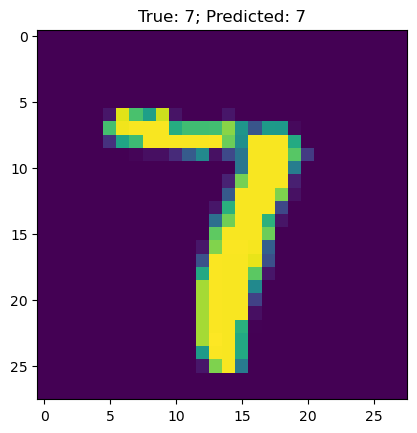

In [375]:
i = int(tf.random.uniform([1], minval=0, maxval=5000, dtype=tf.dtypes.int32))
_input = x_test[i][tf.newaxis,...]
plt.imshow(x_test[i]);
pred = tf.argmax(MOE5.predict(_input), axis=-1)[0]
gating_values = MOE5._get_gating_values(_input)
print(gating_values)
plt.title(f'True: {y_test[i]}; Predicted: {pred}')
plt.show()

In [98]:
model.save_weights('./first_model/first_model')